In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [2]:
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout,Embedding,SpatialDropout1D
from keras.layers import LSTM
from keras.layers.wrappers import Bidirectional
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import roc_auc_score, roc_curve

Using TensorFlow backend.


In [3]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

In [4]:
from sklearn.model_selection import train_test_split

##### Import the dataset

In [5]:
data = pd.read_csv('train.csv')
data.head()

id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation

In [6]:
data.shape

(31962, 3)

In [7]:
data['label'].unique()

array([0, 1], dtype=int64)

##### train test split

In [8]:
X = data['tweet']
y = data['label']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [9]:
y_train.values

array([1, 0, 0, ..., 0, 0, 1], dtype=int64)

In [10]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [11]:
X_train

array(['this is beyond upsetting. i was one of her biggest fans.  #whitepeople  #hawaii #jlaw #disrespect',
       'i miss my friends  ',
       'good morning! â\x98\x80ï¸\x8fð\x9f\x92\x95 stay positive, pray to god &amp; believe! ð\x9f\x98\x81 #vsco #vscocam   #positivity ',
       ...,
       ' @user day 2 of fashion and stem class!   yesterday textile testing. #nevadacubpride ',
       "mayÃ\xado wasn't   when he saw the #headquaers of #loreal in #brussels @ brussels, belgium ",
       "#burbank, #california : cou rejects city's appeal in  discrimination case against #armenian policeman  #usa"],
      dtype=object)

In [12]:
y_train

array([1, 0, 0, ..., 0, 0, 1], dtype=int64)

###### Preprocessing

In [13]:
import nltk

lowercase

In [14]:
#Convert training data into lowercase
lower_train_data = []
for doc in X_train:
    lower_train_data.append(doc.lower())
print(lower_train_data)

#Convert training data into lowercase
lower_test_data = []
for doc in X_test:
    lower_test_data.append(doc.lower())

['this is beyond upsetting. i was one of her biggest fans.  #whitepeople  #hawaii #jlaw #disrespect', 'i miss my friends  ', 'good morning! â\x98\x80ï¸\x8fð\x9f\x92\x95 stay positive, pray to god &amp; believe! ð\x9f\x98\x81 #vsco #vscocam   #positivity ', 'one step closer to uni!!!! #progress   #nursetobe ð\x9f\x91\x93ð\x9f\x92\x8að\x9f\x92\x89ð\x9f\x8c¡ð\x9f\x93\x9dð\x9f\x8f¥', '@user is not a patch on @user horrible atmosphere contestants rude bullying @user @user @user  ', "#findingdory and #orangeisthenewblack both in three days. oh my i'm not getting anything done this weekend.   ð\x9f\x98\x9dð\x9f\x98\x9dð\x9f\x98\x9d", 'i am thankful for the time. #thankful #positive     ', 'such a sad day for uk politics and humanity#murder #terribleday', "my silence doesnâ\x80\x99t mean that i quitâ\x80¦ it simply means th   is doesn't mean forever cause there sad story when the happy is endingî\x81\x96î\x81\x96", '@user you are a #spammer you send #spam you really really really #spam #unwant

In [15]:
lower_train_data[0]

'this is beyond upsetting. i was one of her biggest fans.  #whitepeople  #hawaii #jlaw #disrespect'

In [16]:
lower_test_data[0]

"wouldn't this be in queue in high cou as other cases , how come a film can be supreme priority for cou,   "

Tokenization

In [17]:
# word tokenization
from nltk.tokenize import word_tokenize,wordpunct_tokenize
word_train_token = [wordpunct_tokenize(doc) for doc in lower_train_data]
print(word_train_token)

# word tokenization
from nltk.tokenize import word_tokenize,wordpunct_tokenize
word_test_token = [wordpunct_tokenize(doc) for doc in lower_test_data]

[['this', 'is', 'beyond', 'upsetting', '.', 'i', 'was', 'one', 'of', 'her', 'biggest', 'fans', '.', '#', 'whitepeople', '#', 'hawaii', '#', 'jlaw', '#', 'disrespect'], ['i', 'miss', 'my', 'friends'], ['good', 'morning', '!', 'â', '\x98\x80', 'ï', '¸\x8f', 'ð', '\x9f\x92\x95', 'stay', 'positive', ',', 'pray', 'to', 'god', '&', 'amp', ';', 'believe', '!', 'ð', '\x9f\x98\x81', '#', 'vsco', '#', 'vscocam', '#', 'positivity'], ['one', 'step', 'closer', 'to', 'uni', '!!!!', '#', 'progress', '#', 'nursetobe', 'ð', '\x9f\x91\x93', 'ð', '\x9f\x92\x8a', 'ð', '\x9f\x92\x89', 'ð', '\x9f\x8c¡', 'ð', '\x9f\x93\x9d', 'ð', '\x9f\x8f¥'], ['@', 'user', 'is', 'not', 'a', 'patch', 'on', '@', 'user', 'horrible', 'atmosphere', 'contestants', 'rude', 'bullying', '@', 'user', '@', 'user', '@', 'user'], ['#', 'findingdory', 'and', '#', 'orangeisthenewblack', 'both', 'in', 'three', 'days', '.', 'oh', 'my', 'i', "'", 'm', 'not', 'getting', 'anything', 'done', 'this', 'weekend', '.', 'ð', '\x9f\x98\x9d', 'ð', '\x

Punctuation Removal

In [18]:
#Punctuation Removal
import re
import string

train_no_punctuation = []
test_no_punctuation = []

regex = re.compile('[%s]' % re.escape(string.punctuation))  

#train data
for items in word_train_token:
    new_item = []
    for token in items:
        new_token = re.sub(regex,'',token) # result = re.sub(pattern, replace, string)
        if not new_token == '':
            new_item.append(new_token)
            
    train_no_punctuation.append(new_item)
    
print(train_no_punctuation)


#test data
for items in word_test_token:
    new_item = []
    for token in items:
        new_token = re.sub(regex,'',token) # result = re.sub(pattern, replace, string)
        if not new_token == '':
            new_item.append(new_token)
            
    test_no_punctuation.append(new_item)

[['this', 'is', 'beyond', 'upsetting', 'i', 'was', 'one', 'of', 'her', 'biggest', 'fans', 'whitepeople', 'hawaii', 'jlaw', 'disrespect'], ['i', 'miss', 'my', 'friends'], ['good', 'morning', 'â', '\x98\x80', 'ï', '¸\x8f', 'ð', '\x9f\x92\x95', 'stay', 'positive', 'pray', 'to', 'god', 'amp', 'believe', 'ð', '\x9f\x98\x81', 'vsco', 'vscocam', 'positivity'], ['one', 'step', 'closer', 'to', 'uni', 'progress', 'nursetobe', 'ð', '\x9f\x91\x93', 'ð', '\x9f\x92\x8a', 'ð', '\x9f\x92\x89', 'ð', '\x9f\x8c¡', 'ð', '\x9f\x93\x9d', 'ð', '\x9f\x8f¥'], ['user', 'is', 'not', 'a', 'patch', 'on', 'user', 'horrible', 'atmosphere', 'contestants', 'rude', 'bullying', 'user', 'user', 'user'], ['findingdory', 'and', 'orangeisthenewblack', 'both', 'in', 'three', 'days', 'oh', 'my', 'i', 'm', 'not', 'getting', 'anything', 'done', 'this', 'weekend', 'ð', '\x9f\x98\x9d', 'ð', '\x9f\x98\x9d', 'ð', '\x9f\x98\x9d'], ['i', 'am', 'thankful', 'for', 'the', 'time', 'thankful', 'positive'], ['such', 'a', 'sad', 'day', 'for

Find the max length among all tweets

In [19]:
train_length = []
test_length = []

for elements in train_no_punctuation:
    train_length.append(len(elements))  
print(max(train_length))


for elements in test_no_punctuation:
    test_length.append(len(elements))   
print(max(test_length))

110
112


convert the data into sentences

In [20]:
#train
train_final_list = []
for elements in train_no_punctuation:
    train_final_list.append(" ".join(elements)) 
    
#test
test_final_list = []
for elements in test_no_punctuation:
    test_final_list.append(" ".join(elements)) 

In [21]:
train_final_list

['this is beyond upsetting i was one of her biggest fans whitepeople hawaii jlaw disrespect',
 'i miss my friends',
 'good morning â \x98\x80 ï ¸\x8f ð \x9f\x92\x95 stay positive pray to god amp believe ð \x9f\x98\x81 vsco vscocam positivity',
 'one step closer to uni progress nursetobe ð \x9f\x91\x93 ð \x9f\x92\x8a ð \x9f\x92\x89 ð \x9f\x8c¡ ð \x9f\x93\x9d ð \x9f\x8f¥',
 'user is not a patch on user horrible atmosphere contestants rude bullying user user user',
 'findingdory and orangeisthenewblack both in three days oh my i m not getting anything done this weekend ð \x9f\x98\x9d ð \x9f\x98\x9d ð \x9f\x98\x9d',
 'i am thankful for the time thankful positive',
 'such a sad day for uk politics and humanity murder terribleday',
 'my silence doesnâ \x80\x99 t mean that i quitâ \x80¦ it simply means th is doesn t mean forever cause there sad story when the happy is endingî \x81\x96 î \x81\x96',
 'user you are a spammer you send spam you really really really spam unwantedemail annoyed stop 

In [22]:
test_final_list

['wouldn t this be in queue in high cou as other cases how come a film can be supreme priority for cou',
 'user why isn t season 3 working ivemissedyou',
 'let s clinch the title as well user',
 'i couldn t pull this off but all those colors are so beautiful â \x9d¤ ï ¸\x8f ð \x9f\x92\x9a ð \x9f\x92\x9c ð \x9f\x92\x99 ð \x9f\x92\x9b fashion colors â \x80¦',
 'user ji bihday may all your dreams come true and may you always achieve success in everything you do ð \x9f\x8e\x82',
 'i was watching justin s new clip and thinking abt my days of famous rich',
 'user very excited for september to arrive so our staff can enjoy all those mainis you create',
 'off to the cumberland show',
 'feeling like love by abk â © reversegraffiti â \x9d¤ ï ¸\x8f ð \x9f\x8e¨ paris france',
 'user moving all your products on etsy to your own site takes forever zzzzzzzz be so cool when its done though tâ \x80¦',
 'the revolution occurredâ \x80\x95 just not how marx expected it to â \x80¦ teambts teamsuperjuniorâ 

###### define hyperparameters

In [23]:
epochs = 5
batch_size = 128
n_dim = 64
n_unique_words = 5000
n_words_to_skip = 50

max_tweet_length = 300
drop_embed = 0.2
pad_type = 'pre'
trunc_type = 'pre'

n_rnn = 256
drop_rnn = 0.2

##### Create Embedding layer

In [24]:
voc_size = 10000

#One hot representation - train
train_onehot_repr = [one_hot(items,voc_size)for items in train_final_list]


#One hot representation - test
test_onehot_repr = [one_hot(items,voc_size)for items in test_final_list]

In [25]:
train_onehot_repr

[[9118,
  7205,
  9757,
  2151,
  6207,
  7348,
  544,
  9532,
  5363,
  8222,
  9713,
  585,
  5551,
  7489,
  9443],
 [6207, 4520, 7828, 6136],
 [9857,
  1546,
  6824,
  9671,
  47,
  7491,
  2415,
  5909,
  1276,
  1227,
  3917,
  8567,
  9354,
  1444,
  854,
  2415,
  7099,
  2548,
  1873,
  2922],
 [544,
  1889,
  1986,
  8567,
  9792,
  1626,
  8205,
  2415,
  1429,
  2415,
  7956,
  2415,
  4391,
  2415,
  384,
  2415,
  3227,
  2415,
  278],
 [9025,
  7205,
  1290,
  7220,
  2716,
  1837,
  9025,
  8884,
  871,
  6378,
  3603,
  8155,
  9025,
  9025,
  9025],
 [1788,
  3355,
  1283,
  766,
  5600,
  4889,
  5789,
  8551,
  7828,
  6207,
  4798,
  1290,
  7516,
  3799,
  4806,
  9118,
  7876,
  2415,
  4173,
  2415,
  4173,
  2415,
  4173],
 [6207, 7289, 3590, 7936, 2594, 4866, 3590, 1227],
 [2377, 7220, 2574, 9035, 7936, 1657, 261, 3355, 9533, 1115, 9484],
 [7828,
  8253,
  2926,
  5276,
  7195,
  845,
  1705,
  6207,
  1223,
  6734,
  5312,
  201,
  845,
  1855,
  7205,
  2638

In [26]:
#pad sequences - train

train_pad = pad_sequences(train_onehot_repr,maxlen=max_tweet_length,padding = 'pre',truncating = 'pre')
print(train_pad)

#pad sequences - train

test_pad = pad_sequences(test_onehot_repr,maxlen=max_tweet_length,padding = 'pre',truncating = 'pre')
print(test_pad)

[[   0    0    0 ... 5551 7489 9443]
 [   0    0    0 ... 4520 7828 6136]
 [   0    0    0 ... 2548 1873 2922]
 ...
 [   0    0    0 ... 6692  981 3423]
 [   0    0    0 ... 8728 8728 3293]
 [   0    0    0 ... 6187 2019 3747]]
[[   0    0    0 ... 3384 7936 4703]
 [   0    0    0 ... 6642 1243 1702]
 [   0    0    0 ... 9309 4837 9025]
 ...
 [   0    0    0 ... 8418 4689 7954]
 [   0    0    0 ... 1837 8942 8126]
 [   0    0    0 ... 4114 5747 3597]]


## Design the neural network

#### Bidirectional LSTM

In [27]:
model = Sequential()

model.add(Embedding(input_dim = 10000, output_dim = n_dim, input_length=max_tweet_length))
model.add(SpatialDropout1D(drop_embed))


model.add(Bidirectional(LSTM(units = n_rnn,dropout = drop_rnn)))

model.add(Dense(1, activation = 'sigmoid'))

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 64)           640000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 300, 64)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               657408    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 1,297,921
Trainable params: 1,297,921
Non-trainable params: 0
_________________________________________________________________


###### Compile the model

In [29]:
model.compile(loss='binary_crossentropy',optimizer = 'adam', metrics = ['accuracy'])

In [30]:
os.getcwd()

'C:\\Users\\abdewang.ORADEV\\Data_Science_Preparation\\Project_6'

In [31]:
model.fit(train_pad,y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_split=0.3,callbacks=[EarlyStopping(monitor='val_loss')])

C:\Users\abdewang.ORADEV\AppData\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15661 samples, validate on 6712 samples
Epoch 1/5
15661/15661 [==============================] - 662s 42ms/step - loss: 0.2531 - accuracy: 0.9302 - val_loss: 0.1644 - val_accuracy: 0.9419
Epoch 2/5
15661/15661 [==============================] - 598s 38ms/step - loss: 0.1262 - accuracy: 0.9544 - val_loss: 0.1511 - val_accuracy: 0.9485
Epoch 3/5
15661/15661 [==============================] - 561s 36ms/step - loss: 0.0817 - accuracy: 0.9716 - val_loss: 0.1394 - val_accuracy: 0.9577
Epoch 4/5
15661/15661 [==============================] - 561s 36ms/step - loss: 0.0542 - accuracy: 0.9810 - val_loss: 0.1528 - val_accuracy: 0.9553


In [32]:
y_pred = model.predict(test_pad)

In [33]:
y_pred

array([[2.7123025e-01],
       [1.7866632e-03],
       [7.6570697e-02],
       ...,
       [1.1794458e-05],
       [7.1856222e-05],
       [2.3418683e-05]], dtype=float32)

In [34]:
y_pred_classes = model.predict_classes(test_pad)

In [37]:
np.unique(y_pred_classes)

array([0, 1])

(array([9056.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         533.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

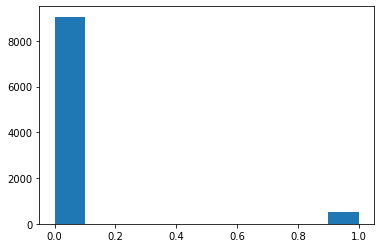

In [38]:
plt.hist(y_pred_classes)

In [39]:
percentage_auc = roc_auc_score(y_test,y_pred) * 100
print(percentage_auc)

92.84559959315317
